In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
class ResidualSwiGLUBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, dim * 2)
        self.fc2 = nn.Linear(dim, dim)
        self.layer_scale = nn.Parameter(0.1 * torch.ones(dim))

    def forward(self, x):
        residual = x
        x = self.norm(x)
        a, b = self.fc1(x).chunk(2, dim=-1)
        x = a * torch.sigmoid(b)
        x = self.fc2(x)
        return residual + x * self.layer_scale

In [3]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        hidden = 1536
        depth = 10

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.LayerNorm(hidden),
        )

        self.blocks = nn.Sequential(
            *[ResidualSwiGLUBlock(hidden) for _ in range(depth)]
        )

        self.output_layer = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        return self.output_layer(x).squeeze(1)

In [4]:
df = pd.read_csv("HIGGS_short.csv")

y = df["label"].values.astype(np.float32)
X = df.drop(columns=["label"]).values.astype(np.float32)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [5]:
class HiggsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32),
        )

test_loader = DataLoader(
    HiggsDataset(X_test, y_test),
    batch_size=8192,
    shuffle=False
)

In [6]:
device = "cuda"

model = DeepMLP(X_train.shape[1]).to(device)

model.load_state_dict(torch.load("Models/DNN.pt", map_location=device))
model.eval()

print("Model loaded.")

Model loaded.


ROC-AUC: 0.8852485957954259
PR-AUC: 0.8950870941683227
ACC: 0.7998577145829805


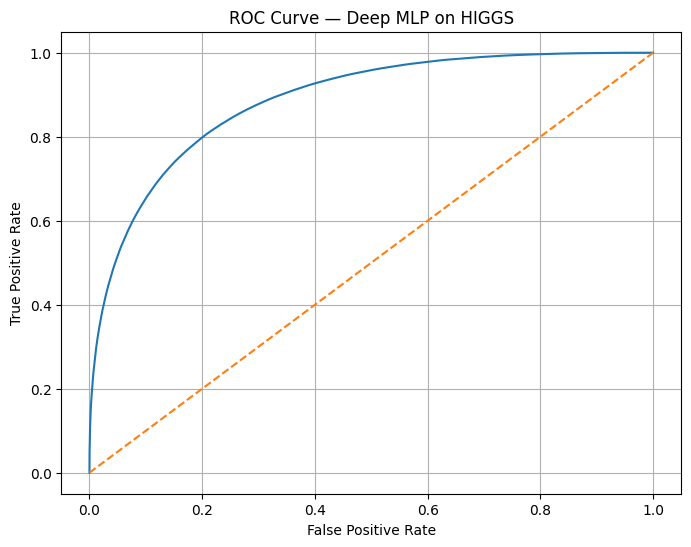

In [7]:
preds, trues = [], []

with torch.no_grad(), autocast(device_type=device):
    for xb, yb in test_loader:
        xb = xb.to(device)
        prob = torch.sigmoid(model(xb))
        preds.append(prob.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

print("ROC-AUC:", roc_auc_score(trues, preds))
print("PR-AUC:", average_precision_score(trues, preds))
print("ACC:", accuracy_score(trues, (preds > 0.5).astype(int)))

fpr, tpr, _ = roc_curve(trues, preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Deep MLP on HIGGS")
plt.grid(True)
plt.savefig("roc_curve_dnn.png", dpi=300)
plt.show()